In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [11]:
df = pd.read_csv("train.csv",header=None, names=['sentiment','text'],encoding='ISO-8859-1')
# df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})
df

sentiment                                               text
NaN       sentiment                                               text
1.0               0           is so sad for my APL friend.............
2.0               0                   I missed the New Moon trailer...
3.0               1                            omg its already 7:30 :O
4.0               0  Omgaga. Im sooo  im gunna CRy. I've been at th...
...             ...                                                ...
99996.0           0  @Cupcake  seems like a repeating problem   hop...
99997.0           1  @cupcake__ arrrr we both replied to each other...
99998.0           0                      @CuPcAkE_2120 ya i thought so
99999.0           1  @Cupcake_Dollie Yes. Yes. I'm glad you had mor...
100000.0          1                     @cupcake_kayla haha yes you do

[99989 rows x 2 columns]

In [6]:
%%time
print ("Cleaning the tweets...\n")
clean_tweet_texts = []
for i in range(0,len(df)):
    if( (i+1)%100000 == 0 ):
        print ("Tweets %d of %d has been processed" % ( i+1, len(df) ))                                                                    
    clean_tweet_texts.append(tweet_cleaner_updated(df['text'][i]))

Cleaning the tweets...



KeyError: 0.0

In [23]:
clean_df = pd.DataFrame(clean_tweet_texts,columns=['text'])
clean_df['target'] = df.sentiment
clean_df.to_csv('clean_tweet2.csv',encoding='utf-8')

In [24]:
csv = 'clean_tweet2.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()

text  target
0                                               text     NaN
1                        is so sad for my apl friend     NaN
2                        missed the new moon trailer     NaN
3                                    omg its already     NaN
4  omgaga im sooo im gunna cry ve been at this de...     NaN

After cleaning the tweets with the updated cleaner function, I took another look at the info()

In [7]:
my_df.shape

(1600000, 2)

In [8]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
text      1596041 non-null object
target    1600000 non-null int64
dtypes: int64(1), object(1)
memory usage: 36.6+ MB


In [10]:
my_df[my_df.isnull().any(axis=1)].head()

text  target
208  NaN       0
249  NaN       0
282  NaN       0
398  NaN       0
430  NaN       0

In [11]:
np.sum(my_df.isnull().any(axis=1))

3959

In [12]:
my_df.isnull().any(axis=0)

text       True
target    False
dtype: bool

It seems like 3,981 entries have null entries for the text column. This is strange, because the original dataset had no null entries, and if there are any null entries in the cleaned dataset,
it must have happened during the cleaning process.

In [13]:
df = pd.read_csv("./trainingandtestdata/training.1600000.processed.noemoticon.csv",header=None,encoding='ISO-8859-1')
df.iloc[my_df[my_df.isnull().any(axis=1)].index,:].head()

0           1                             2         3             4  \
208  0  1467863072  Mon Apr 06 22:33:25 PDT 2009  NO_QUERY      Artiel87   
249  0  1467874569  Mon Apr 06 22:36:27 PDT 2009  NO_QUERY      Artiel87   
282  0  1467881474  Mon Apr 06 22:38:20 PDT 2009  NO_QUERY     __Susan__   
398  0  1467912842  Mon Apr 06 22:46:53 PDT 2009  NO_QUERY  KimberlyKane   
430  0  1467919452  Mon Apr 06 22:48:48 PDT 2009  NO_QUERY     jtmal0723   

                         5  
208             @mandayyy   
249           @mandayyy     
282  @ITS_NEMESIS -------   
398         @danadearmond   
430             @anistorm

By looking at these entries in the original data, it seems like only text information they had was either twitter ID or it could have been URL address.
Anyway, these are the info I decided to discard for the sentiment analysis, so I will drop these null rows, and update the data frame.

In [14]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596041 entries, 0 to 1596040
Data columns (total 2 columns):
text      1596041 non-null object
target    1596041 non-null int64
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


# Word Cloud

The first text visualisation I chose is the controversial word cloud.
A word cloud represents word usage in a document by resizing individual words proportionally to its frequency and then presenting them in a random arrangement.
There were a lot of debates around word cloud, and I somewhat agree with the points of anti-wordcloud's view.
Some of the concerns over word cloud is that,
it supports only the crudest sorts of textual analysis,
and it is often applied to situations where textual analysis is not appropriate,
and it leaves viewers to figure out the context of the data by themselves without providing the narrative.

But in the case of tweets, textual analysis is the most important analysis,
and it provides a general idea of what kind of words are frequent in the corpus,
in a sort of quick and dirty way.
So, I will give it a go, and figure out what other methods can be used for text visualisation.

For the word cloud, I used the python library wordcloud.

In [15]:
neg_tweets = my_df[my_df.target == 0]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

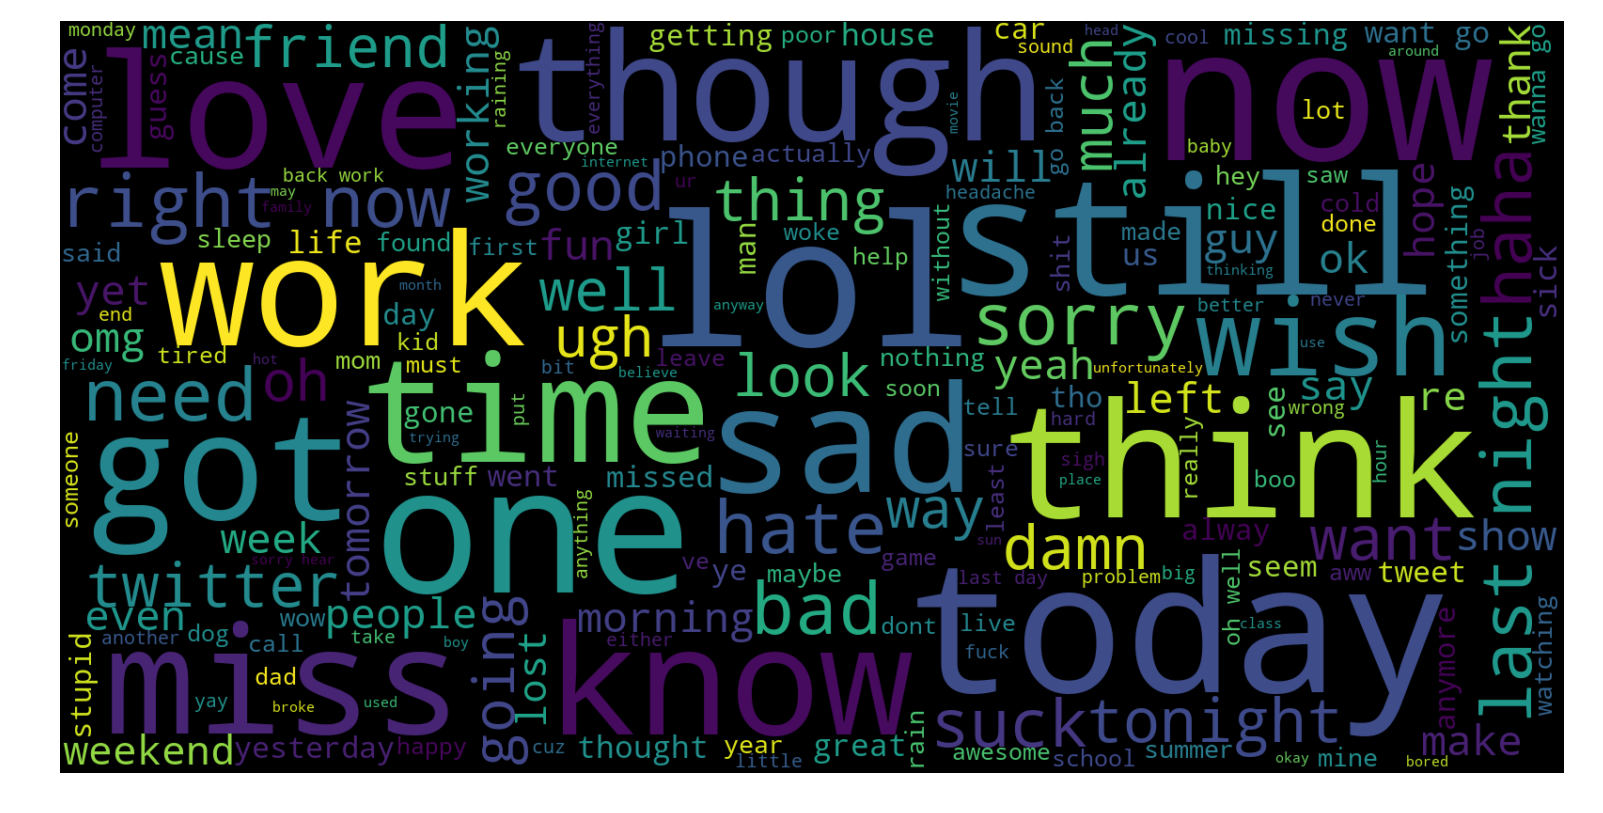

In [16]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Some of the big words can be interpreted quite neutral, such as "today","now", etc.
I can see some of the words in smaller size make sense to be in negative tweets,
such as "damn","ugh","miss","bad", etc.
But there is "love" in a rather big size, so I wanted to see what is happening.

In [17]:
for t in neg_tweets.text[:200]:
    if 'love' in t:
        print (t)

ahh ive always wanted to see rent love the soundtrack
meh almost lover is the exception this track gets me depressed every time
awe love you too am here miss you
damn the grind is inspirational and saddening at the same time do not want you to stop cuz like what do much love
missing you babe but as long as your alive happy ya tired my love imma try to sleep hopefully you had headstart
love the french tell people here in the south qtr french and they snarl at me french are beautiful people


OK, even though the tweets contain the word "love", in these cases it is negative sentiment because the tweet has mixed emotions like "love" but "miss". Or sometimes used in a sarcastic way.

In [18]:
pos_tweets = my_df[my_df.target == 1]
pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

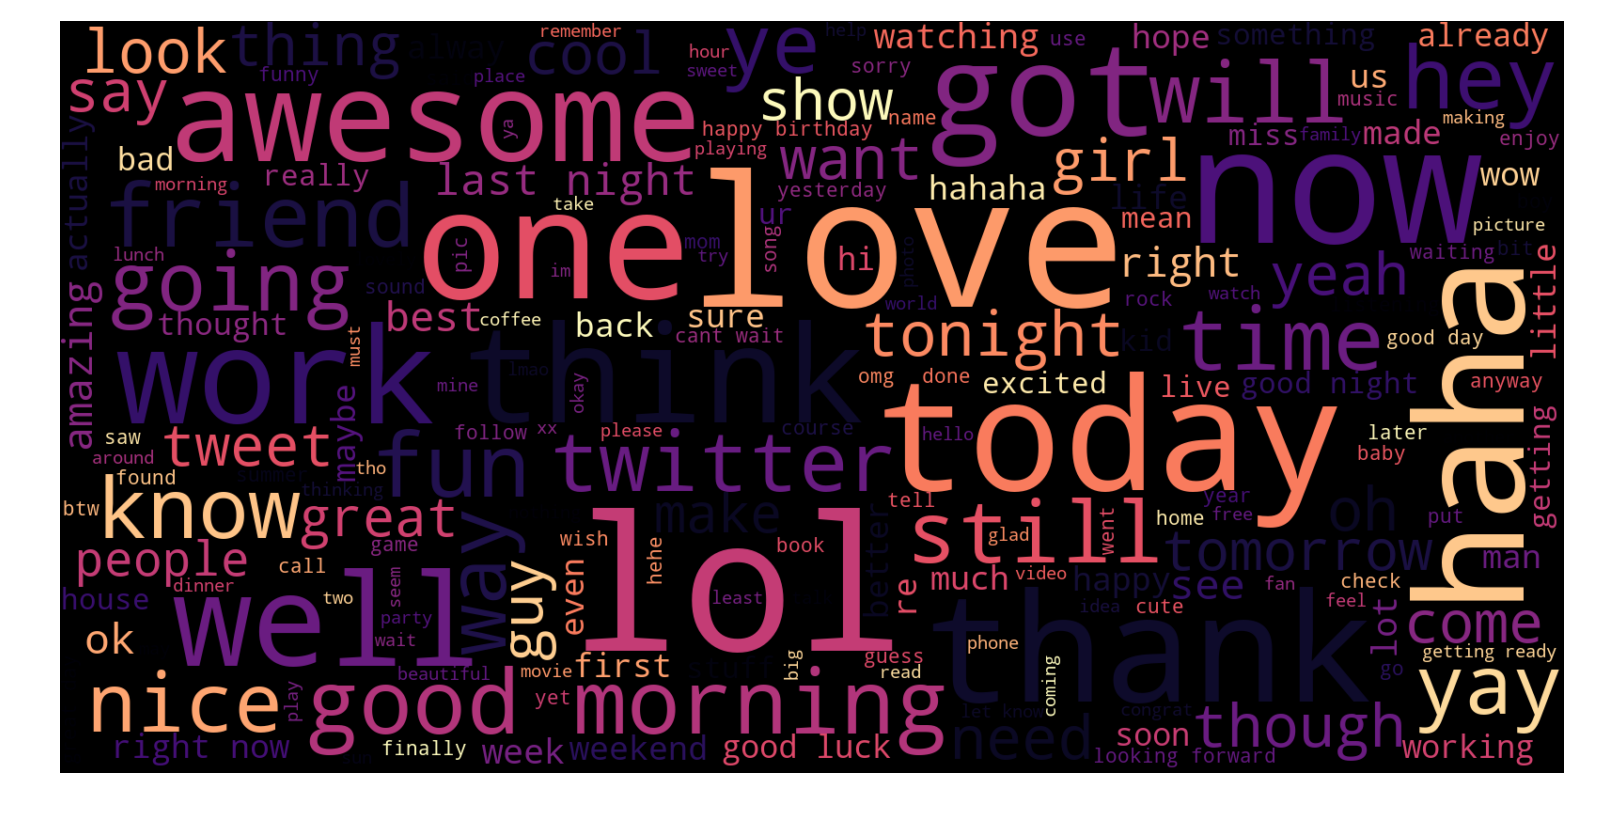

In [19]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Again I see some neutral words in big size, "today","now",
but words like "haha", "love", "awesome" also stand out.

Interestingly, the word "work" was quite big in the negative word cloud, but also quite big in the positive word cloud.
It might imply that many people express negative sentiment towards work, but also many people are positive about works.

In [20]:
del pos_tweets, pos_string, neg_tweets, neg_string, wordcloud, df

## Preparion for data visualisation

In order for me to implement a couple of data visualisation in the next step, I need term frequency data.
What kind of words are used in the tweets, and how many times it is used in entire corpus.
I used count vectorizer to calculate the term frequencies, the count vectorizer is also for fit, train and predict,
but at this stage, I will just be extracting the term frequencies for the visualisation.

There are parameter options available for count vectorizer, such as removing stop words, limiting the maximum number of terms.
However, in order to get a full picture of the dataset first, I implemented with stop words included, and not limiting the maximum number of terms.

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit(my_df.text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [22]:
cvec.get_feature_names()

['aa',
 'aaa',
 'aaaa',
 'aaaaa',
 'aaaaaa',
 'aaaaaaa',
 'aaaaaaaa',
 'aaaaaaaaa',
 'aaaaaaaaaa',
 'aaaaaaaaaaa',
 'aaaaaaaaaaaa',
 'aaaaaaaaaaaaa',
 'aaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaah',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaah',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaargh',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaall',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaao',
 'aaaaaaaaaaaaaaaaaaaaaaaaaargh',
 'aaaaaaaaaaaaaaaaaaaaaaah',
 'aaaaaaaaaaaaaaaaaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh',
 'aaaaaaaaaaaaaaaaaaaaaaahrg',
 'aaaaaaaaaaaaaaaaaaaaah',
 'aaaaaaaaaaaaaaaaaaaaahhhhh',
 'aaaaaaaaaaaaaaaaaaaah',
 'aaaaaaaaaaaaaaaaaaaaint',
 'aaa

In [23]:
len(cvec.get_feature_names())

264939

OK it looks like count vectorizer has extracted 264936 words out of the corpus.

In [24]:
neg_doc_matrix = cvec.transform(my_df[my_df.target == 0].text)
pos_doc_matrix = cvec.transform(my_df[my_df.target == 1].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()

Getting term frequency for each class can be obtained with the above code block, but below is what I have implemented at first when I didn't know that I didn't have to transform sparse matrix to dense one. However I will leave the below part as I have done before.

-------------------------------------------------------------------------------------------------------

For below part, I had to go through many trial and errors, because of the memory usage overload.
If the code takes time to implement, but still running, it is OK,
but it was not the matter of how long it takes the block to run,
my mac book pro just simply gave up and either killed the kernel or froze.
After numerous attempts, I have finally succeded in processing the data in batches.
The mistake I kept making was, when I slice the document matrix,
I tried to slice it in 'document_matrix.toarray()[start_index,end_index]',
and I finally realised because I was trying to first convert whole documnet_matrix to array, and then slice from there,
no matter how I change the batch size, my poor macbook pro couldn't handle the request.
After I change my slicing to 'document_matrix[start_index,end_index].toarray()',
my macbook pro did a wonderful job for me.

In [25]:
document_matrix = cvec.transform(my_df.text)

In [26]:
my_df[my_df.target == 0].tail()

text  target
798192    sick spending my day laying in bed listening to       0
798193                                      gmail is down       0
798194                        rest in peace farrah so sad       0
798195  sounds like rival is flagging your ads not muc...       0
798196  has to resit exams over summer wishes he worke...       0

In [27]:
# %%time
# neg_batches = np.linspace(0,798179,100).astype(int)
# i=0
# neg_tf = []
# while i < len(neg_batches)-1:
#     batch_result = np.sum(document_matrix[neg_batches[i]:neg_batches[i+1]].toarray(),axis=0)
#     neg_tf.append(batch_result)
#     if (i % 10 == 0) | (i == len(neg_batches)-2):
#         print (neg_batches[i+1],"entries' term freuquency calculated")
#     i += 1

8062 entries' term freuquency calculated
88686 entries' term freuquency calculated
169310 entries' term freuquency calculated
249934 entries' term freuquency calculated
330558 entries' term freuquency calculated
411183 entries' term freuquency calculated
491807 entries' term freuquency calculated
572431 entries' term freuquency calculated
653055 entries' term freuquency calculated
733679 entries' term freuquency calculated
798179 entries' term freuquency calculated
CPU times: user 12min 27s, sys: 16min 56s, total: 29min 23s
Wall time: 31min 32s


In [28]:
# my_df.tail()

text  target
1596036  just woke up having no school is the best feel...       1
1596037   thewdb com very cool to hear old walt interviews       1
1596038  are you ready for your mojo makeover ask me fo...       1
1596039  happy th birthday to my boo of alll time tupac...       1
1596040                               happy charitytuesday       1

In [29]:
# %%time
# pos_batches = np.linspace(798179,1596019,100).astype(int)
# i=0
# pos_tf = []
# while i < len(pos_batches)-1:
#     batch_result = np.sum(document_matrix[pos_batches[i]:pos_batches[i+1]].toarray(),axis=0)
#     pos_tf.append(batch_result)
#     if (i % 10 == 0) | (i == len(pos_batches)-2):
#         print (pos_batches[i+1],"entries' term freuquency calculated")
#     i += 1

806237 entries' term freuquency calculated
886827 entries' term freuquency calculated
967417 entries' term freuquency calculated
1048007 entries' term freuquency calculated
1128597 entries' term freuquency calculated
1209187 entries' term freuquency calculated
1289777 entries' term freuquency calculated
1370367 entries' term freuquency calculated
1450957 entries' term freuquency calculated
1531547 entries' term freuquency calculated
1596019 entries' term freuquency calculated
CPU times: user 12min 36s, sys: 17min 10s, total: 29min 46s
Wall time: 30min 53s


In [30]:
# neg = np.sum(neg_tf,axis=0)
# pos = np.sum(pos_tf,axis=0)
# term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
# term_freq_df.head()

0   1
aa      160  92
aaa      93  54
aaaa     45  29
aaaaa    26  12
aaaaaa   16  12

In [31]:
# term_freq_df.columns = ['negative', 'positive']
# term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
# term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

negative  positive   total
to     313155    252567  565722
the    257834    265993  523827
my     190767    125957  316724
it     157444    147786  305230
and    153954    149642  303596
you    103842    198243  302085
not    194719     86865  281584
is     133429    111191  244620
in     115540    101158  216698
for     98999    117366  216365

In [32]:
# len(term_freq_df)

264939

In [33]:
# term_freq_df.to_csv('term_freq_df.csv',encoding='utf-8')

In [34]:
my_df.head()

text  target
0  awww that bummer you shoulda got david carr of...       0
1  is upset that he can not update his facebook b...       0
2  dived many times for the ball managed to save ...       0
3     my whole body feels itchy and like its on fire       0
4  no it not behaving at all mad why am here beca...       0

In [35]:
x = my_df.text
y = my_df.target

In [36]:
from sklearn.model_selection import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [37]:
print ("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),
                                                                             (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
                                                                            (len(x_train[y_train == 1]) / (len(x_train)*1.))*100))
print ("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),
                                                                             (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,
                                                                            (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100))
print ("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),
                                                                             (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
                                                                            (len(x_test[y_test == 1]) / (len(x_test)*1.))*100))

Train set has total 1564120 entries with 50.02% negative, 49.98% positive
Validation set has total 15960 entries with 49.45% negative, 50.55% positive
Test set has total 15961 entries with 49.68% negative, 50.32% positive


In [38]:
from textblob import TextBlob
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

In [39]:
%%time
tbresult = [TextBlob(i).sentiment.polarity for i in x_validation]
tbpred = [0 if n < 0 else 1 for n in tbresult]

CPU times: user 3.82 s, sys: 57.8 ms, total: 3.88 s
Wall time: 3.98 s


In [40]:
conmat = np.array(confusion_matrix(y_validation, tbpred, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['positive', 'negative'],
                         columns=['predicted_positive','predicted_negative'])
print ("Accuracy Score: {0:.2f}%".format(accuracy_score(y_validation, tbpred)*100))
print ("-"*80)
print ("Confusion Matrix\n")
print (confusion)
print ("-"*80)
print ("Classification Report\n")
print (classification_report(y_validation, tbpred))

Accuracy Score: 61.84%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_positive  predicted_negative
positive                7282                 785
negative                5306                2587
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

           0       0.77      0.33      0.46      7893
           1       0.58      0.90      0.71      8067

    accuracy                           0.62     15960
   macro avg       0.67      0.62      0.58     15960
weighted avg       0.67      0.62      0.58     15960



In [41]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time

In [42]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("train and test time: {0:.2f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, train_test_time

In [43]:
cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000,100001,10000)

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print ("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

In [44]:
count_vect = CountVectorizer(ngram_range=(1,2))

corpus = [
    'This is the first document.',
    'This is the second second document.',
]
X = count_vect.fit_transform(corpus)
print(X)
print(count_vect.get_feature_names())
['first document', 'is the', 'second document', 'second second', 'the first', 'the second', 'this is']

  (0, 11)	1
  (0, 3)	1
  (0, 8)	1
  (0, 1)	1
  (0, 0)	1
  (0, 12)	1
  (0, 4)	1
  (0, 9)	1
  (0, 2)	1
  (1, 11)	1
  (1, 3)	1
  (1, 8)	1
  (1, 0)	1
  (1, 12)	1
  (1, 4)	1
  (1, 5)	2
  (1, 10)	1
  (1, 7)	1
  (1, 6)	1
['document', 'first', 'first document', 'is', 'is the', 'second', 'second document', 'second second', 'the', 'the first', 'the second', 'this', 'this is']


['first document',
 'is the',
 'second document',
 'second second',
 'the first',
 'the second',
 'this is']

In [55]:
%%time
print ("RESULT FOR UNIGRAM WITHOUT STOP WORDS\n")
feature_result_wosw = nfeature_accuracy_checker(stop_words='english')

RESULT FOR UNIGRAM WITHOUT STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


Validation result for 10000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 77.35%
model is 26.80% more accurate than null accuracy
train and test time: 98.97s
--------------------------------------------------------------------------------
Validation result for 20000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 77.66%
model is 27.11% more accurate than null accuracy
train and test time: 75.44s
--------------------------------------------------------------------------------
Validation result for 30000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 77.78%
model is 27.24% more accurate than null accuracy
train and test time: 90.42s
--------------------------------------------------------------------------------
Validation result for 40000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 77.72%
model is 27.17% more accurate than null accuracy
train and test time: 99.45s
--------------------------------------------------------------------------------
Validation result for 50000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 77.74%
model is 27.19% more accurate than null accuracy
train and test time: 107.91s
--------------------------------------------------------------------------------
Validation result for 60000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 77.86%
model is 27.31% more accurate than null accuracy
train and test time: 102.84s
--------------------------------------------------------------------------------
Validation result for 70000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 77.86%
model is 27.31% more accurate than null accuracy
train and test time: 123.22s
--------------------------------------------------------------------------------
Validation result for 80000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 77.78%
model is 27.24% more accurate than null accuracy
train and test time: 100.26s
--------------------------------------------------------------------------------
Validation result for 90000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 77.79%
model is 27.25% more accurate than null accuracy
train and test time: 113.96s
--------------------------------------------------------------------------------
Validation result for 100000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 77.77%
model is 27.22% more accurate than null accuracy
train and test time: 127.35s
--------------------------------------------------------------------------------
CPU times: user 25min 7s, sys: 1min 2s, total: 26min 10s
Wall time: 17min 20s


In [57]:
%%time
print ("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_ug = nfeature_accuracy_checker()

RESULT FOR UNIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


Validation result for 10000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.66%
model is 29.11% more accurate than null accuracy
train and test time: 116.67s
--------------------------------------------------------------------------------
Validation result for 20000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.82%
model is 29.27% more accurate than null accuracy
train and test time: 155.56s
--------------------------------------------------------------------------------
Validation result for 30000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.76%
model is 29.22% more accurate than null accuracy
train and test time: 174.30s
--------------------------------------------------------------------------------
Validation result for 40000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.77%
model is 29.22% more accurate than null accuracy
train and test time: 169.73s
--------------------------------------------------------------------------------
Validation result for 50000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.84%
model is 29.29% more accurate than null accuracy
train and test time: 192.16s
--------------------------------------------------------------------------------
Validation result for 60000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.86%
model is 29.32% more accurate than null accuracy
train and test time: 218.84s
--------------------------------------------------------------------------------
Validation result for 70000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.94%
model is 29.39% more accurate than null accuracy
train and test time: 212.45s
--------------------------------------------------------------------------------
Validation result for 80000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.96%
model is 29.41% more accurate than null accuracy
train and test time: 192.18s
--------------------------------------------------------------------------------
Validation result for 90000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 80.01%
model is 29.47% more accurate than null accuracy
train and test time: 242.85s
--------------------------------------------------------------------------------
Validation result for 100000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 80.02%
model is 29.47% more accurate than null accuracy
train and test time: 219.24s
--------------------------------------------------------------------------------
CPU times: user 45min 30s, sys: 1min 40s, total: 47min 11s
Wall time: 31min 34s


In [54]:
csv = 'term_freq_df.csv'
term_freq_df = pd.read_csv(csv,index_col=0)
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

negative  positive   total
to     313155    252567  565722
the    257834    265993  523827
my     190767    125957  316724
it     157444    147786  305230
and    153954    149642  303596
you    103842    198243  302085
not    194719     86865  281584
is     133429    111191  244620
in     115540    101158  216698
for     98999    117366  216365

In [46]:
from sklearn.feature_extraction import text

a = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:10].index))
b = text.ENGLISH_STOP_WORDS
set(a).issubset(set(b))

True

In [47]:
my_stop_words = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:10].index))

In [62]:
%%time
print ("RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS (Top 10 frequent words)\n")
feature_result_wocsw = nfeature_accuracy_checker(stop_words=my_stop_words)

RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS (Top 10 frequent words)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


Validation result for 10000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 78.84%
model is 28.30% more accurate than null accuracy
train and test time: 91.28s
--------------------------------------------------------------------------------
Validation result for 20000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.00%
model is 28.45% more accurate than null accuracy
train and test time: 104.92s
--------------------------------------------------------------------------------
Validation result for 30000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.04%
model is 28.50% more accurate than null accuracy
train and test time: 122.18s
--------------------------------------------------------------------------------
Validation result for 40000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.05%
model is 28.51% more accurate than null accuracy
train and test time: 155.68s
--------------------------------------------------------------------------------
Validation result for 50000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.04%
model is 28.49% more accurate than null accuracy
train and test time: 188.20s
--------------------------------------------------------------------------------
Validation result for 60000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.10%
model is 28.56% more accurate than null accuracy
train and test time: 176.80s
--------------------------------------------------------------------------------
Validation result for 70000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.11%
model is 28.57% more accurate than null accuracy
train and test time: 167.33s
--------------------------------------------------------------------------------
Validation result for 80000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.10%
model is 28.55% more accurate than null accuracy
train and test time: 196.27s
--------------------------------------------------------------------------------
Validation result for 90000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.05%
model is 28.50% more accurate than null accuracy
train and test time: 175.45s
--------------------------------------------------------------------------------
Validation result for 100000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.04%
model is 28.49% more accurate than null accuracy
train and test time: 172.29s
--------------------------------------------------------------------------------
CPU times: user 36min 40s, sys: 1min 24s, total: 38min 4s
Wall time: 25min 50s


In [48]:
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug_wocsw = pd.DataFrame(feature_result_wocsw,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug_wosw = pd.DataFrame(feature_result_wosw,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='with stop words')
plt.plot(nfeatures_plot_ug_wocsw.nfeatures, nfeatures_plot_ug_wocsw.validation_accuracy,label='without custom stop words')
plt.plot(nfeatures_plot_ug_wosw.nfeatures, nfeatures_plot_ug_wosw.validation_accuracy,label='without stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

NameError: name 'feature_result_ug' is not defined

In [65]:
%%time
print ("RESULT FOR BIGRAM WITH STOP WORDS\n")
feature_result_bg = nfeature_accuracy_checker(ngram_range=(1, 2))

RESULT FOR BIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


Validation result for 10000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 80.58%
model is 30.04% more accurate than null accuracy
train and test time: 226.07s
--------------------------------------------------------------------------------
Validation result for 20000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 81.39%
model is 30.85% more accurate than null accuracy
train and test time: 243.24s
--------------------------------------------------------------------------------
Validation result for 30000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 81.79%
model is 31.24% more accurate than null accuracy
train and test time: 217.23s
--------------------------------------------------------------------------------
Validation result for 40000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 81.90%
model is 31.36% more accurate than null accuracy
train and test time: 263.18s
--------------------------------------------------------------------------------
Validation result for 50000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 81.93%
model is 31.38% more accurate than null accuracy
train and test time: 374.57s
--------------------------------------------------------------------------------
Validation result for 60000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 81.99%
model is 31.45% more accurate than null accuracy
train and test time: 404.65s
--------------------------------------------------------------------------------
Validation result for 70000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 82.22%
model is 31.67% more accurate than null accuracy
train and test time: 417.31s
--------------------------------------------------------------------------------
Validation result for 80000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 82.05%
model is 31.50% more accurate than null accuracy
train and test time: 616.72s
--------------------------------------------------------------------------------
Validation result for 90000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 82.14%
model is 31.60% more accurate than null accuracy
train and test time: 729.23s
--------------------------------------------------------------------------------
Validation result for 100000 features


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 82.17%
model is 31.62% more accurate than null accuracy
train and test time: 877.37s
--------------------------------------------------------------------------------
CPU times: user 1h 22min 16s, sys: 6min 49s, total: 1h 29min 5s
Wall time: 1h 12min 50s


In [49]:
# nfeatures_plot_tg = pd.DataFrame(feature_result_tg,columns=['nfeatures','validation_accuracy','train_test_time'])
# nfeatures_plot_bg = pd.DataFrame(feature_result_bg,columns=['nfeatures','validation_accuracy','train_test_time'])
# nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])

# plt.figure(figsize=(8,6))
# plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram')
# plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram')
# plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram')
# plt.title("N-gram(1~3) test result : Accuracy")
# plt.xlabel("Number of features")
# plt.ylabel("Validation set accuracy")
# plt.legend()

In [51]:
def train_test_and_evaluate(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[0,1]))
    confusion = pd.DataFrame(conmat, index=['negative', 'positive'],
                         columns=['predicted_negative','predicted_positive'])
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("-"*80)
    print ("Confusion Matrix\n")
    print (confusion)
    print ("-"*80)
    print ("Classification Report\n")
    print (classification_report(y_test, y_pred, target_names=['negative','positive']))

In [52]:
%%time
ug_cvec = CountVectorizer(max_features=80000)
ug_pipeline = Pipeline([
        ('vectorizer', ug_cvec),
        ('classifier', lr)
    ])
train_test_and_evaluate(ug_pipeline, x_train, y_train, x_validation, y_validation)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 79.96%
model is 29.41% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                6140                1753
positive                1446                6621
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

    negative       0.81      0.78      0.79      7893
    positive       0.79      0.82      0.81      8067

    accuracy                           0.80     15960
   macro avg       0.80      0.80      0.80     15960
weighted avg       0.80      0.80      0.80     15960

CPU times: user 5min 16s, sys: 12.1 s, total: 5min 28s
Wall time: 3min 17s


In [53]:
%%time
bg_cvec = CountVectorizer(max_features=70000,ngram_range=(1, 2))
bg_pipeline = Pipeline([
        ('vectorizer', bg_cvec),
        ('classifier', lr)
    ])
train_test_and_evaluate(bg_pipeline, x_train, y_train, x_validation, y_validation)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


null accuracy: 50.55%
accuracy score: 82.22%
model is 31.67% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                6323                1570
positive                1268                6799
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

    negative       0.83      0.80      0.82      7893
    positive       0.81      0.84      0.83      8067

    accuracy                           0.82     15960
   macro avg       0.82      0.82      0.82     15960
weighted avg       0.82      0.82      0.82     15960

CPU times: user 9min 15s, sys: 51.3 s, total: 10min 6s
Wall time: 7min 59s
